In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import json
from umd.umd_data_gen import _corpus_loader
from transformers import AutoTokenizer
from datasets import Dataset

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

In [7]:
df_tok_ana = _corpus_loader("umd_reddit_suicidewatch_dataset_v2/crowd/test/shared_task_posts_test.csv","umd_reddit_suicidewatch_dataset_v2/crowd/test/crowd_test_A.csv")

In [26]:
df_tok_ana = _corpus_loader("umd_reddit_suicidewatch_dataset_v2/expert/expert_posts.csv","umd_reddit_suicidewatch_dataset_v2/expert/expert.csv")

In [75]:
df_post = pd.read_csv("umd_reddit_suicidewatch_dataset_v2/expert/expert_posts.csv")
# filter out non-negative user_id
df_post = df_post[df_post["user_id"] >= 0]
# for each user_id, get all posts, concatenate them into one string
df_post_long = df_post.fillna("").groupby("user_id")["post_body"].apply(lambda x: ",".join(x)).reset_index()
df_crowd = pd.read_csv("umd_reddit_suicidewatch_dataset_v2/expert/expert.csv")
df_suicidewatch = pd.merge(
    df_post_long, df_crowd, on="user_id"
)
# create a dataframe with all post body and label
df_suicidewatch_body = df_suicidewatch[["post_body", "label"]].copy()
# rename the column name
df_suicidewatch_body = df_suicidewatch_body.rename(columns={"post_body": "text"})
df_suicidewatch_corpus = df_suicidewatch_body
# remove rows with text length less than 2
df_tok_ana = df_suicidewatch_corpus[
    df_suicidewatch_corpus["text"].str.split().str.len() > 1
]

# n-grams test

In [3]:
# tfidf
def _word_ngrams(tokens,ngram_range=(1,1) ,stop_words=None):
    """Turn tokens into a sequence of n-grams after stop words filtering"""
    # handle stop words
    if stop_words is not None:
        tokens = [w for w in tokens if w not in stop_words]

    # handle token n-grams
    min_n, max_n = ngram_range
    if max_n != 1:
        original_tokens = tokens
        if min_n == 1:
            # no need to do any slicing for unigrams
            # just iterate through the original tokens
            tokens = list(original_tokens)
            min_n += 1
        else:
            tokens = []

        n_original_tokens = len(original_tokens)

        # bind method outside of loop to reduce overhead
        tokens_append = tokens.append
        space_join = " ".join

        for n in range(min_n, min(max_n + 1, n_original_tokens + 1)):
            for i in range(n_original_tokens - n + 1):
                tokens_append(space_join(original_tokens[i : i + n]))

    return tokens


In [89]:
_word_ngrams([123,333],ngram_range=(2,2))

TypeError: sequence item 0: expected str instance, int found

In [3]:
vectorizer = CountVectorizer()

,text,label
0,I was at party. When everyone were having fun....,a
1,"Hi. So for starters, I take Zoloft, 75g; they ...",c
2,I apologize in advance for this being so long....,d
3,I made a thread yesterday where I expressed a ...,d
6,"I tried last night, but threw up the pills. I ...",d
...,...,...
914,Not even using a throwaway anymore. I don't ca...,a
915,"This is maybe my third time posting, previousl...",d
916,not sure if this is the right place to post th...,a
917,I have always struggled with suicide ever sinc...,d


# tfidf token level

In [8]:
def tokenize_df(df_corpus, model_name, seed=42, eval=False):
    """
    Tokenize the corpus using the model_name.
    :param df_corpus: a pandas dataframe with two columns: text and label
    :param model_name: the name of the model
    :return: a dictionary with keys "input_ids", "attention_mask", "label"
    """
    # load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # load df into Dataset
    dataset = Dataset.from_pandas(df_corpus)

    if eval:
        tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"]), batched=True)
    else:
        # tokenize the corpus
        tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=512), batched=True)

        # format object to be used by the model
        tokenized_dataset = tokenized_dataset.remove_columns(["text"])
        tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
        tokenized_dataset.set_format("torch")
        tokenized_dataset = tokenized_dataset.shuffle(seed=seed)
    return tokenized_dataset

In [77]:
df_tok = tokenize_df(df_tok_ana, "mental/mental-roberta-base", eval=True)

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (7855 > 512). Running this sequence through the model will result in indexing errors


In [78]:
df_tok_ana = df_tok.to_pandas()

In [79]:
# Flatten the 'input_ids' column to get the vocabulary
vocab = set([token for sublist in df_tok_ana['input_ids'] for token in sublist])

# Create a dictionary to map token ids to indices
token_to_idx = {token: i for i, token in enumerate(vocab)}

# Initialize count matrix as sparse matrix for memory efficiency
count_matrix = csr_matrix((len(df_tok_ana), len(vocab)), dtype=np.int8)

# Populate count matrix
for i, doc in df_tok_ana['input_ids'].iteritems():
    for token in doc:
        if token in token_to_idx:
            # deal with out of vocabulary tokens
            count_matrix[i, token_to_idx[token]] += 1

# Initialize tfidf transformer
tfidf_transformer = TfidfTransformer()

# Fit and transform count matrix
tfidf_transformer.fit(count_matrix)
# revert the idf_ to the textbook formula
# tfidf_transformer.idf_ = tfidf_transformer.idf_-1
tfidf_matrix = tfidf_transformer.transform(count_matrix)

# Convert the tfidf_matrix (a sparse matrix) into a DataFrame
# Convert token ids to tokens
tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
vocab_tokens = [tokenizer.decode([id]) for id in vocab]
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=vocab_tokens)

# Concatenate the original DataFrame with the tfidf_df
# rename the text and label column as _text and _label
df_tok_ana = df_tok_ana.rename(columns={"text": "_text", "label": "_label"})
result_df = pd.concat([df_tok_ana, tfidf_df], axis=1)

In [80]:
df_attributions = pd.read_json("word_attributions.json")
# transpose df
df_attributions = df_attributions.T
# find median attribution for each label
df_attributions['median_LABEL_0'] = df_attributions['LABEL_0'].apply(lambda x: np.median(x))
df_attributions['median_LABEL_1'] = df_attributions['LABEL_1'].apply(lambda x: np.median(x))
df_attributions['median_LABEL_2'] = df_attributions['LABEL_2'].apply(lambda x: np.median(x))
df_attributions['median_LABEL_3'] = df_attributions['LABEL_3'].apply(lambda x: np.median(x))
# find mean attribution for each label
df_attributions['mean_LABEL_0'] = df_attributions['LABEL_0'].apply(lambda x: np.mean(x))
df_attributions['mean_LABEL_1'] = df_attributions['LABEL_1'].apply(lambda x: np.mean(x))
df_attributions['mean_LABEL_2'] = df_attributions['LABEL_2'].apply(lambda x: np.mean(x))
df_attributions['mean_LABEL_3'] = df_attributions['LABEL_3'].apply(lambda x: np.mean(x))
# convert to dictionary with format {"median":"token":{"LABEL_0":median, "LABEL_1":median, "LABEL_2":median, "LABEL_3":median}, "mean":"token":{"LABEL_0":mean, "LABEL_1":mean, "LABEL_2":mean, "LABEL_3":mean}}
df_attributions_dict = df_attributions.to_dict()

In [81]:
def get_score(result_df,label="LABEL_0",attribution_type="median",use_tfidf=True,non_vocab_score=0.0):
    # for each column from index 5 to the end in result_df, multiply tfidf_df by the median attribution for label 0, then sum the columns
    result_df_temp = result_df.copy()
    index_key = f"{attribution_type}_{label}"
    if use_tfidf:
        for col in result_df_temp.columns[5:]:
            if col not in df_attributions_dict[index_key]:
                result_df_temp[col] = result_df_temp[col].astype(float) * non_vocab_score
                continue
            try:
                result_df_temp[col] = result_df_temp[col].astype(float) * df_attributions_dict[index_key][col]
            except:
                print(col)
                raise
        result_df_temp[label] = result_df_temp[result_df_temp.columns[5:]].sum(axis=1)
    else:
        result_df_temp = result_df_temp[["_text", "_label","input_ids"]]
        # convert list input_ids to list of tokens
        tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
        result_df_temp["input_ids"] = result_df_temp["input_ids"].apply(lambda x: [tokenizer.decode([id]) for id in x])
        # find attribution of each token
        result_df_temp["attribution"] = result_df_temp["input_ids"].apply(lambda x: [df_attributions_dict[index_key][token] if token in df_attributions_dict[index_key] else non_vocab_score for token in x])
        # sum attribution for each text to label column
        result_df_temp[label] = result_df_temp["attribution"].apply(lambda x: sum(x))
    # drop all columns except for _text, _label, and attribution label
    result_df_temp = result_df_temp[['_text', '_label', label]]
    return result_df_temp

In [82]:
def get_result_df(result_df, attribution_type="median", use_tfidf=True, non_vocab_score=0.0):
    result_df_label_0 = get_score(result_df,label="LABEL_0",attribution_type=attribution_type,use_tfidf=use_tfidf,non_vocab_score=non_vocab_score)
    result_df_label_1 = get_score(result_df,label="LABEL_1",attribution_type=attribution_type,use_tfidf=use_tfidf,non_vocab_score=non_vocab_score)
    result_df_label_2 = get_score(result_df,label="LABEL_2",attribution_type=attribution_type,use_tfidf=use_tfidf,non_vocab_score=non_vocab_score)
    result_df_label_3 = get_score(result_df,label="LABEL_3",attribution_type=attribution_type,use_tfidf=use_tfidf,non_vocab_score=non_vocab_score)
    # join all the result_df_median together
    result_df_label = result_df_label_0.merge(result_df_label_1, on=['_text', '_label'], how='left')
    result_df_label = result_df_label.merge(result_df_label_2, on=['_text', '_label'], how='left')
    result_df_label = result_df_label.merge(result_df_label_3, on=['_text', '_label'], how='left')
    # find label with max attribution
    result_df_label['label_predict'] = result_df_label[['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3']].idxmax(axis=1)
    # map LABEL_0 to a, LABEL_1 to b, LABEL_2 to c, LABEL_3 to d
    mapper = {'LABEL_0': 'a', 'LABEL_1': 'b', 'LABEL_2': 'c', 'LABEL_3': 'd'}
    result_df_label['label_predict'] = result_df_label['label_predict'].map(mapper)
    # rename _label to label
    result_df_label = result_df_label.rename(columns={"_label": "label"})
    return result_df_label

# Ablation

Limit: TFIDF fitted on /r/SuicideWatch only

In [83]:
result_df_median = get_result_df(result_df, attribution_type="median", use_tfidf=False, non_vocab_score=0.0)
result_df_mean = get_result_df(result_df, attribution_type="mean", use_tfidf=False, non_vocab_score=0.0)
result_df_median_tfidf = get_result_df(result_df, attribution_type="median", use_tfidf=True, non_vocab_score=0.0)
result_df_mean_tfidf = get_result_df(result_df, attribution_type="mean", use_tfidf=True, non_vocab_score=0.0)
# non_vocab score doesn't make sense since they are not from attribution dict means that they should not affect the score (define)
# result_df_median_tfidf_non_vocab = get_result_df(result_df, attribution_type="median", use_tfidf=True, non_vocab_score=1.0)
# result_df_mean_tfidf_non_vocab = get_result_df(result_df, attribution_type="mean", use_tfidf=True, non_vocab_score=1.0)

In [84]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
def get_classification_report(result_df):
    print(classification_report(result_df['label'], result_df['label_predict'], digits=4))
    cm = confusion_matrix(result_df['label'], result_df['label_predict'], labels=['a', 'b', 'c', 'd'])
    df_cm = pd.DataFrame(cm, index=['a', 'b', 'c', 'd'], columns=['a', 'b', 'c', 'd'])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def get_classification_report_any_risk(result_df):
    # make another copy of df_corpus
    df_corpus_bcd = result_df.copy()
    # group b,c,d to label b, run classification report and confusion matrix again
    df_corpus_bcd['label_predict'] = df_corpus_bcd['label_predict'].apply(lambda x: 'b' if x in ['b', 'c', 'd'] else x)
    df_corpus_bcd['label'] = df_corpus_bcd['label'].apply(lambda x: 'b' if x in ['b', 'c', 'd'] else x)
    print(classification_report(df_corpus_bcd['label'], df_corpus_bcd['label_predict'], digits=4))
    cm = confusion_matrix(df_corpus_bcd['label'], df_corpus_bcd['label_predict'])
    df_cm = pd.DataFrame(cm, index = ["No Risk", "Any Risk"],
                        columns = ["No Risk", "Any Risk"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

def get_classification_report_low_high_risk(result_df):
    # make another copy of df_corpus
    df_corpus_ab_cd = result_df.copy()
    # group a,b to a, c,d to d, run classification report and confusion matrix again
    df_corpus_ab_cd['label_predict'] = df_corpus_ab_cd['label_predict'].apply(lambda x: 'a' if x in ['a', 'b'] else 'd')
    df_corpus_ab_cd['label'] = df_corpus_ab_cd['label'].apply(lambda x: 'a' if x in ['a', 'b'] else 'd')
    print(classification_report(df_corpus_ab_cd['label'], df_corpus_ab_cd['label_predict'], digits=4))
    cm = confusion_matrix(df_corpus_ab_cd['label'], df_corpus_ab_cd['label_predict'])
    df_cm = pd.DataFrame(cm, index = ["Low Risk", "High Risk"], 
                        columns = ["Low Risk", "High Risk"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

## Median no TFIDF

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.5000    0.0200    0.0385        50
           c     0.0000    0.0000    0.0000       115
           d     0.1811    1.0000    0.3066        44

    accuracy                         0.1837       245
   macro avg     0.1703    0.2550    0.0863       245
weighted avg     0.1346    0.1837    0.0629       245



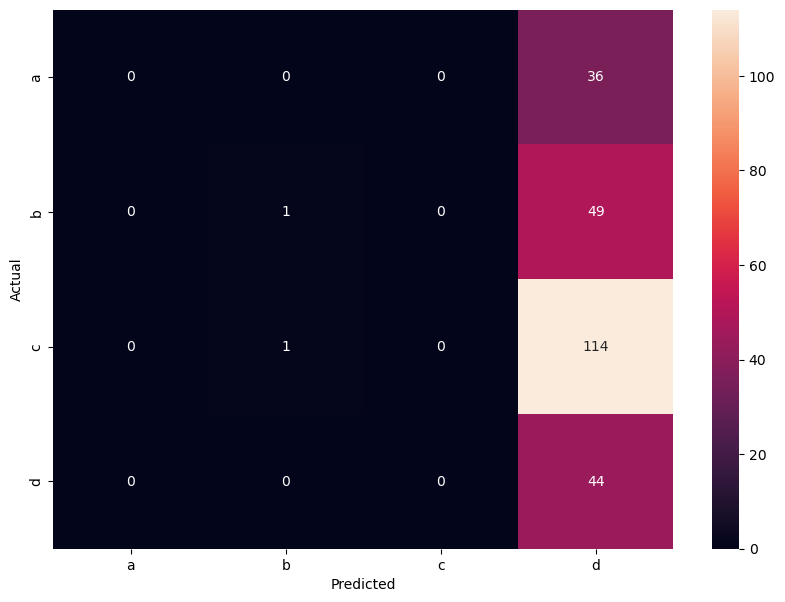

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.8531    1.0000    0.9207       209

    accuracy                         0.8531       245
   macro avg     0.4265    0.5000    0.4604       245
weighted avg     0.7277    0.8531    0.7854       245



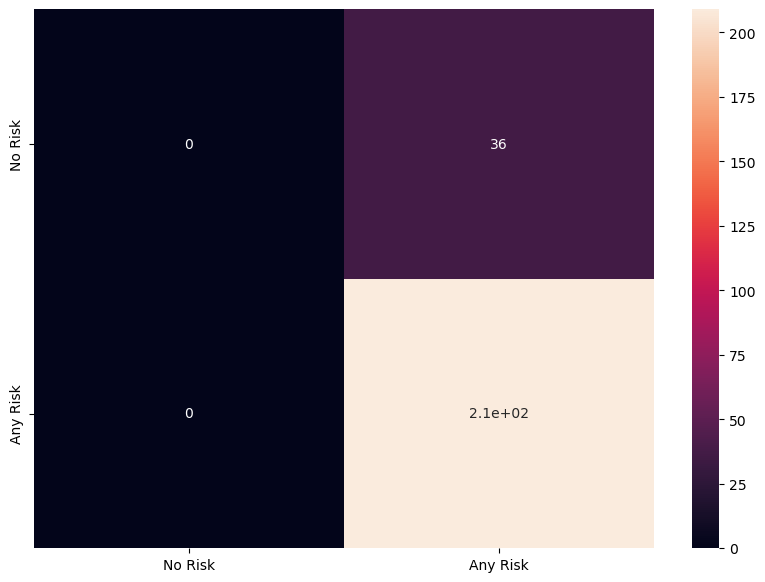

              precision    recall  f1-score   support

           a     0.5000    0.0116    0.0227        86
           d     0.6502    0.9937    0.7861       159

    accuracy                         0.6490       245
   macro avg     0.5751    0.5027    0.4044       245
weighted avg     0.5975    0.6490    0.5181       245



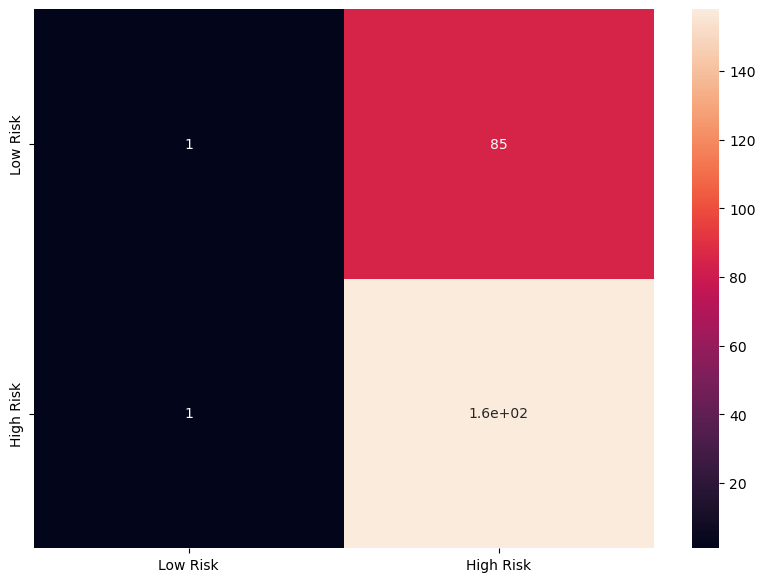

In [86]:
get_classification_report(result_df_median)
get_classification_report_any_risk(result_df_median)
get_classification_report_low_high_risk(result_df_median)

## Mean no TFIDF

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.2500    0.0200    0.0370        50
           c     0.0000    0.0000    0.0000       115
           d     0.1743    0.9545    0.2947        44

    accuracy                         0.1755       245
   macro avg     0.1061    0.2436    0.0829       245
weighted avg     0.0823    0.1755    0.0605       245



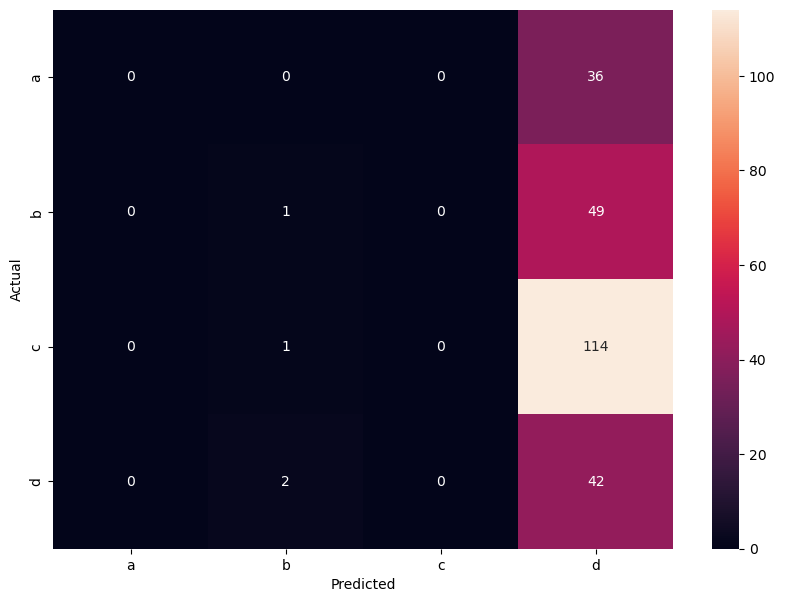

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.8531    1.0000    0.9207       209

    accuracy                         0.8531       245
   macro avg     0.4265    0.5000    0.4604       245
weighted avg     0.7277    0.8531    0.7854       245



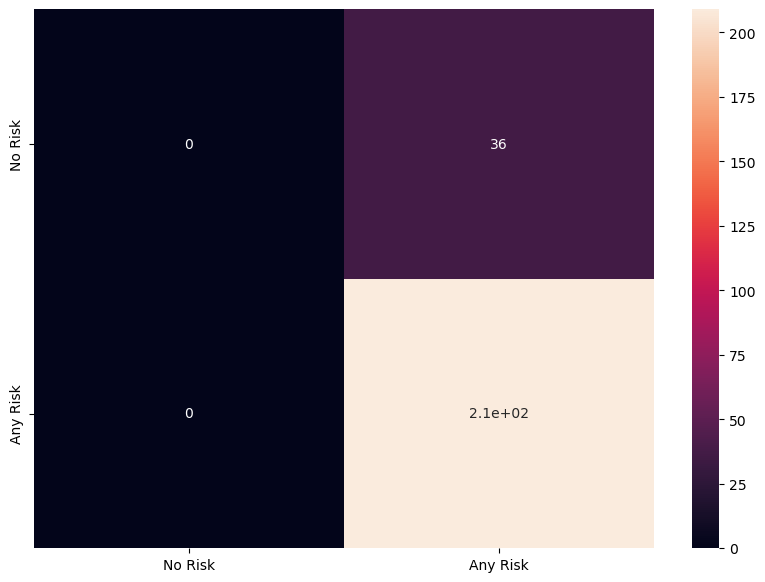

              precision    recall  f1-score   support

           a     0.2500    0.0116    0.0222        86
           d     0.6473    0.9811    0.7800       159

    accuracy                         0.6408       245
   macro avg     0.4487    0.4964    0.4011       245
weighted avg     0.5078    0.6408    0.5140       245



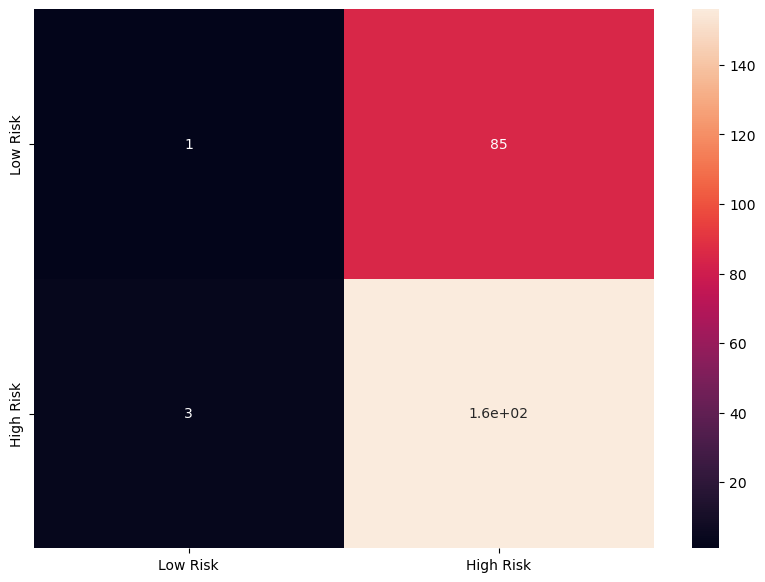

In [87]:
get_classification_report(result_df_mean)
get_classification_report_any_risk(result_df_mean)
get_classification_report_low_high_risk(result_df_mean)

## Median with TFIDF

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.1176    0.0400    0.0597        50
           c     0.0000    0.0000    0.0000       115
           d     0.1806    0.9318    0.3026        44

    accuracy                         0.1755       245
   macro avg     0.0746    0.2430    0.0906       245
weighted avg     0.0564    0.1755    0.0665       245



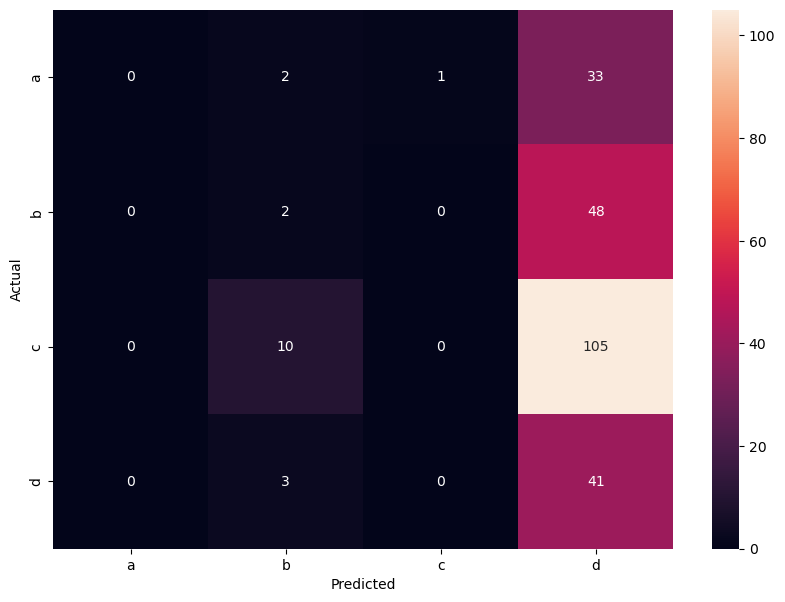

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.8531    1.0000    0.9207       209

    accuracy                         0.8531       245
   macro avg     0.4265    0.5000    0.4604       245
weighted avg     0.7277    0.8531    0.7854       245



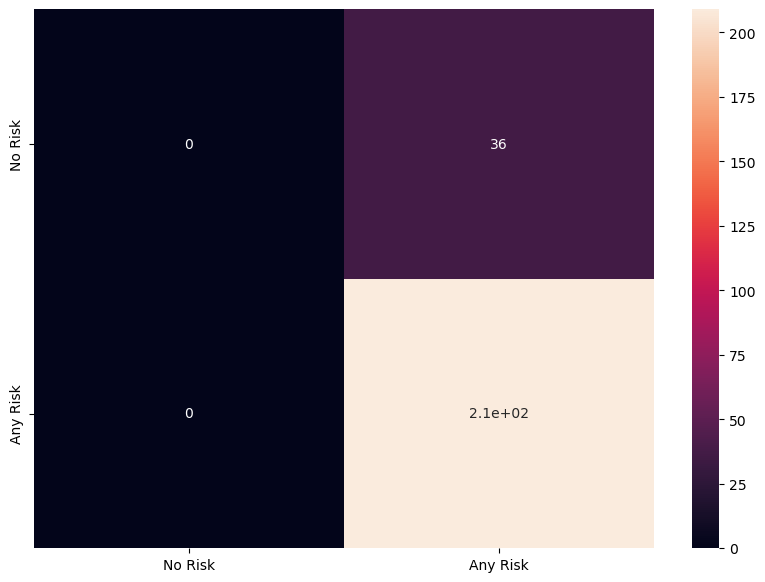

              precision    recall  f1-score   support

           a     0.2353    0.0465    0.0777        86
           d     0.6404    0.9182    0.7545       159

    accuracy                         0.6122       245
   macro avg     0.4378    0.4824    0.4161       245
weighted avg     0.4982    0.6122    0.5169       245



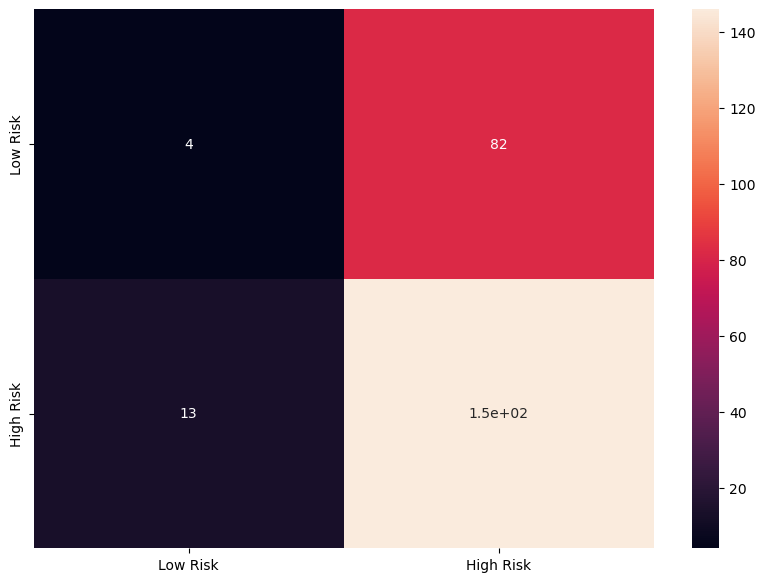

In [88]:
get_classification_report(result_df_median_tfidf)
get_classification_report_any_risk(result_df_median_tfidf)
get_classification_report_low_high_risk(result_df_median_tfidf)

## Mean with TFIDF

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.1000    0.0400    0.0571        50
           c     0.0000    0.0000    0.0000       115
           d     0.1830    0.9318    0.3060        44

    accuracy                         0.1755       245
   macro avg     0.0708    0.2430    0.0908       245
weighted avg     0.0533    0.1755    0.0666       245



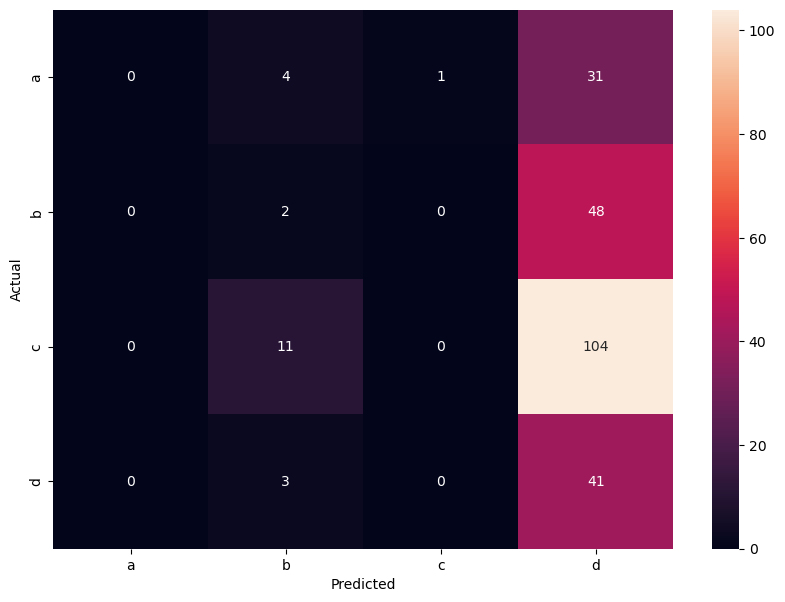

              precision    recall  f1-score   support

           a     0.0000    0.0000    0.0000        36
           b     0.8531    1.0000    0.9207       209

    accuracy                         0.8531       245
   macro avg     0.4265    0.5000    0.4604       245
weighted avg     0.7277    0.8531    0.7854       245



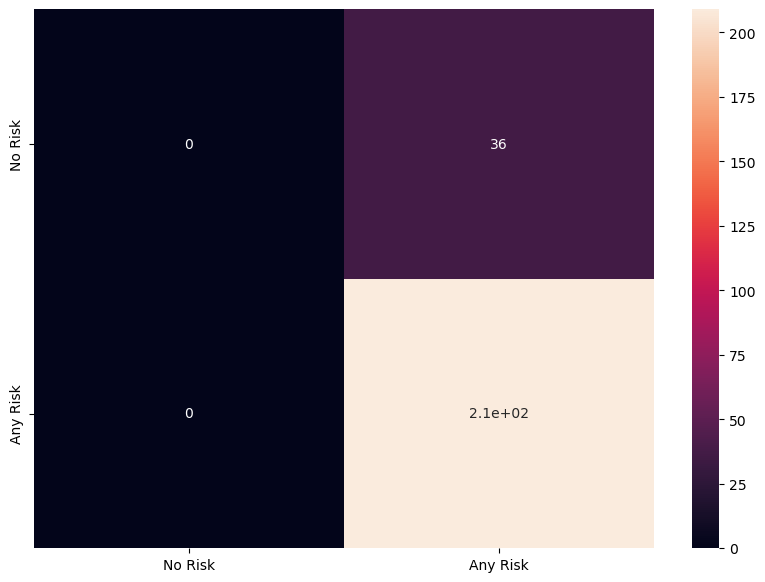

              precision    recall  f1-score   support

           a     0.3000    0.0698    0.1132        86
           d     0.6444    0.9119    0.7552       159

    accuracy                         0.6163       245
   macro avg     0.4722    0.4909    0.4342       245
weighted avg     0.5235    0.6163    0.5299       245



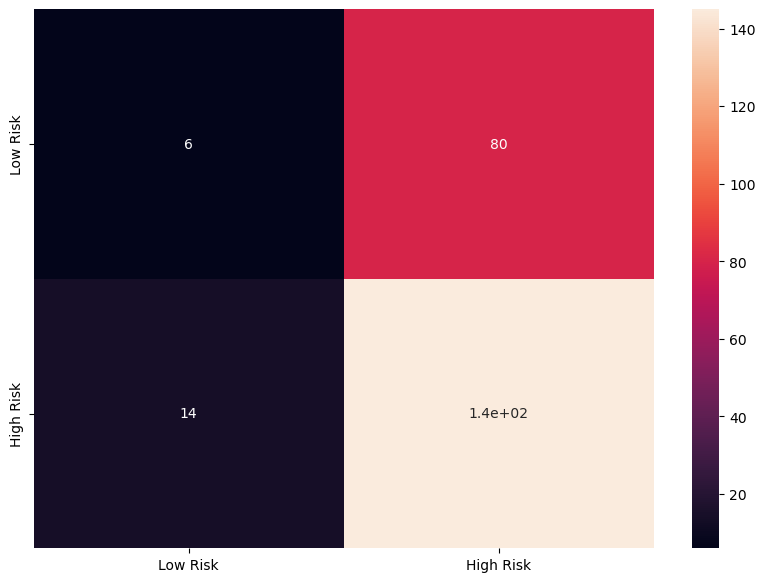

In [89]:
get_classification_report(result_df_mean_tfidf)
get_classification_report_any_risk(result_df_mean_tfidf)
get_classification_report_low_high_risk(result_df_mean_tfidf)